In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
from scipy.stats import pearsonr
import NPI
from NPI_Enhanced import train_with_masking, train_with_snr_weights, train_multi_resolution, compute_confidence_weighted_EC, map_coarse_to_fine_EC
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def flat_without_diagonal(matrix):
    n = matrix.shape[0]
    return np.array([matrix[i][j] for i in range(n) for j in list(range(i)) + list(range(i + 1, n))])

def block_correlation(EC_inferred, EC_true, n_thal):
    r, _ = pearsonr(flat_without_diagonal(EC_inferred), flat_without_diagonal(EC_true))
    return r

def print_block_results(r, label=''):
    print(f'\n{label}')
    print(f'  r = {r:.3f}')

In [ ]:
DATA_DIR = '/content'

N_THAL = 15
N_CORT = 35
ROI_num = N_THAL + N_CORT  # 50

batch_size = 64
train_set_proportion = 0.8
using_steps = 3

## 1. Baseline (Uniform SNR, No Smoothing)

In [ ]:
signals_base = np.loadtxt(f'{DATA_DIR}/thalcort_baseline_signal.txt')
real_EC_base = np.loadtxt(f'{DATA_DIR}/thalcort_baseline_real_EC.txt')

inputs_base, targets_base = NPI.multi2one(signals_base, steps=using_steps)

ANN_baseline = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
ANN_baseline, train_loss, test_loss = NPI.train_NN(
    ANN_baseline, inputs_base, targets_base, batch_size, train_set_proportion,
    num_epochs=100, lr=2.5e-4, l2=5e-5
)

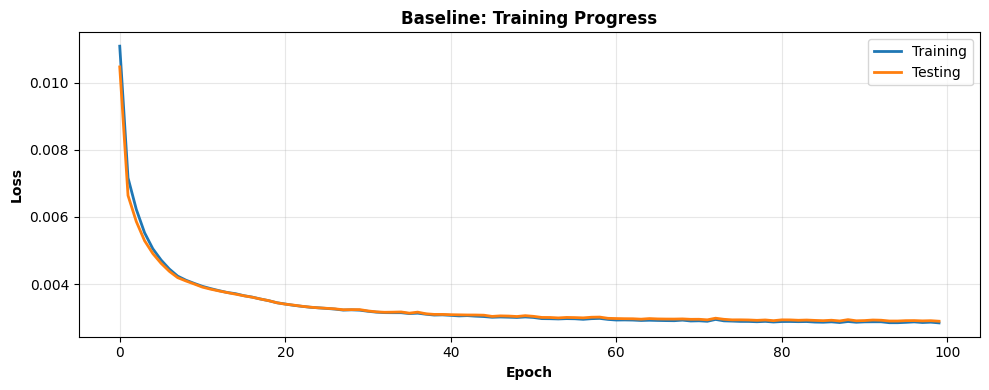

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='Training', linewidth=2)
plt.plot(test_loss, label='Testing', linewidth=2)
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.title('Baseline: Training Progress', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
EC_baseline = NPI.model_EC(ANN_baseline, inputs_base, targets_base, pert_strength=1.0)
np.fill_diagonal(EC_baseline, 0)

r_base = block_correlation(EC_baseline, real_EC_base, N_THAL)
print_block_results(r_base, 'Baseline')


Baseline
  r = 0.753


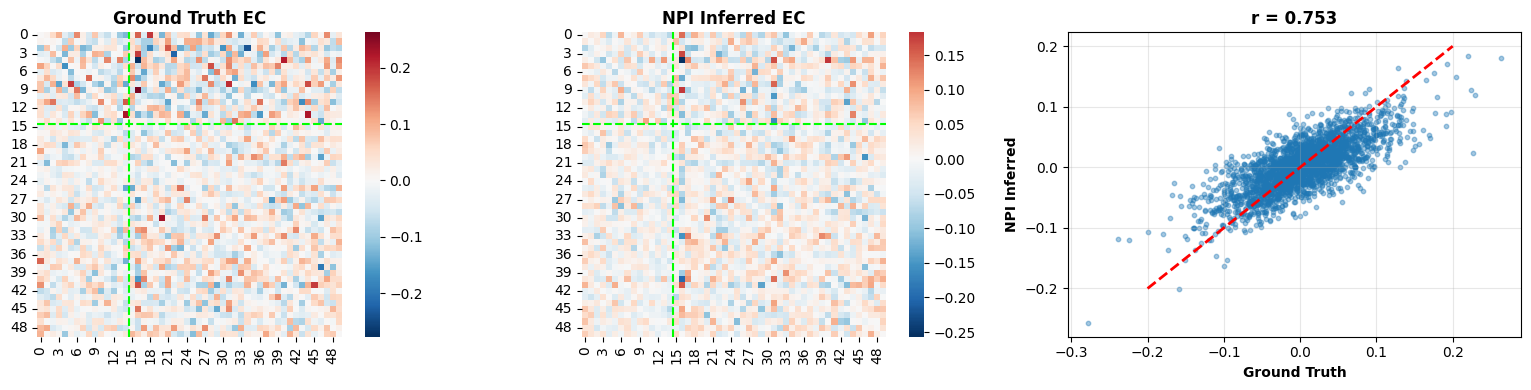

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.heatmap(real_EC_base, cmap='RdBu_r', center=0, ax=axes[0], square=True)
axes[0].axhline(y=N_THAL, color='lime', linewidth=1.5, linestyle='--')
axes[0].axvline(x=N_THAL, color='lime', linewidth=1.5, linestyle='--')
axes[0].set_title('Ground Truth EC', fontweight='bold')

sns.heatmap(EC_baseline, cmap='RdBu_r', center=0, ax=axes[1], square=True)
axes[1].axhline(y=N_THAL, color='lime', linewidth=1.5, linestyle='--')
axes[1].axvline(x=N_THAL, color='lime', linewidth=1.5, linestyle='--')
axes[1].set_title('NPI Inferred EC', fontweight='bold')

axes[2].scatter(flat_without_diagonal(real_EC_base), flat_without_diagonal(EC_baseline), alpha=0.4, s=10)
axes[2].plot([-0.2, 0.2], [-0.2, 0.2], 'r--', linewidth=2)
axes[2].set_xlabel('Ground Truth', fontweight='bold')
axes[2].set_ylabel('NPI Inferred', fontweight='bold')
axes[2].set_title(f'r = {r_base:.3f}', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Heterogeneous SNR (Low Thal, High Cort)

In [ ]:
signals_snr = np.loadtxt(f'{DATA_DIR}/thalcort_snr_only_signal.txt')
real_EC_snr = np.loadtxt(f'{DATA_DIR}/thalcort_snr_only_real_EC.txt')
SNR_snr = np.loadtxt(f'{DATA_DIR}/thalcort_snr_only_SNR.txt')

inputs_snr, targets_snr = NPI.multi2one(signals_snr, steps=using_steps)
inputs_snr_t = torch.FloatTensor(inputs_snr)
targets_snr_t = torch.FloatTensor(targets_snr)

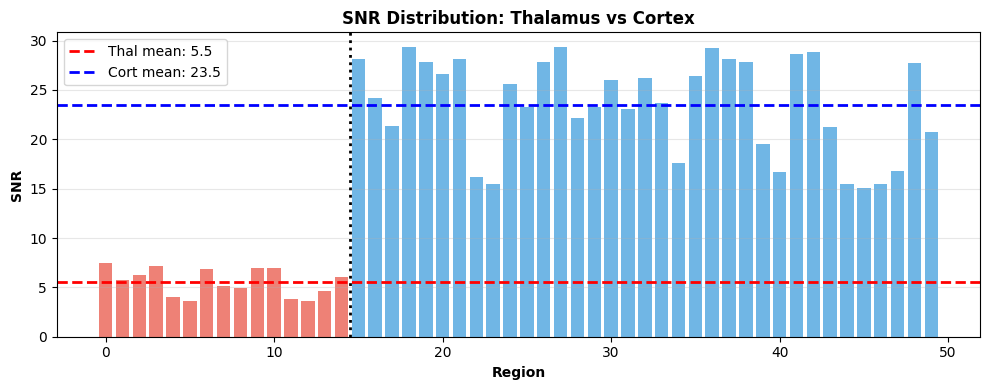

In [ ]:
plt.figure(figsize=(10, 4))
colors = ['#E74C3C'] * N_THAL + ['#3498DB'] * N_CORT
plt.bar(range(ROI_num), SNR_snr, color=colors, alpha=0.7)
plt.axhline(y=SNR_snr[:N_THAL].mean(), color='red', linestyle='--', linewidth=2, label=f'Thal mean: {SNR_snr[:N_THAL].mean():.1f}')
plt.axhline(y=SNR_snr[N_THAL:].mean(), color='blue', linestyle='--', linewidth=2, label=f'Cort mean: {SNR_snr[N_THAL:].mean():.1f}')
plt.axvline(x=N_THAL - 0.5, color='black', linestyle=':', linewidth=2)
plt.xlabel('Region', fontweight='bold')
plt.ylabel('SNR', fontweight='bold')
plt.title('SNR Distribution: Thalamus vs Cortex', fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 2.1 Standard Training

In [ ]:
ANN_snr_std = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
ANN_snr_std, _, _ = NPI.train_NN(ANN_snr_std, inputs_snr, targets_snr, batch_size, train_set_proportion, num_epochs=100, lr=2.5e-4, l2=5e-5)

EC_snr_std = NPI.model_EC(ANN_snr_std, inputs_snr, targets_snr, pert_strength=1.0)
np.fill_diagonal(EC_snr_std, 0)

r_snr_std = block_correlation(EC_snr_std, real_EC_snr, N_THAL)
print_block_results(r_snr_std, 'SNR Only (Standard)')


SNR Only (Standard)
  r = 0.800


### 2.2 SNR-Weighted Training

In [ ]:
ANN_snr_wt = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
ANN_snr_wt, _, _ = train_with_snr_weights(
    ANN_snr_wt, inputs_snr_t, targets_snr_t, SNR_snr,
    batch_size, train_set_proportion, num_epochs=100, lr=2.5e-4, l2=5e-5,
    weight_strategy='log', weight_strength=0.3
)

EC_snr_wt = NPI.model_EC(ANN_snr_wt, inputs_snr_t, targets_snr_t, pert_strength=1.0)
np.fill_diagonal(EC_snr_wt, 0)

r_snr_wt = block_correlation(EC_snr_wt, real_EC_snr, N_THAL)
print_block_results(r_snr_wt, 'SNR Only (Weighted)')

/content/NPI_Enhanced.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(input_X[:int(train_set_proportion * input_X.shape[0])], dtype=torch.float).to(device)
/content/NPI_Enhanced.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(target_Y[:int(train_set_proportion * target_Y.shape[0])], dtype=torch.float).to(device)
/content/NPI_Enhanced.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(input_X[int(train_set_proportion * input_X.shape[0]):], dtype


SNR Only (Weighted)
  r = 0.796


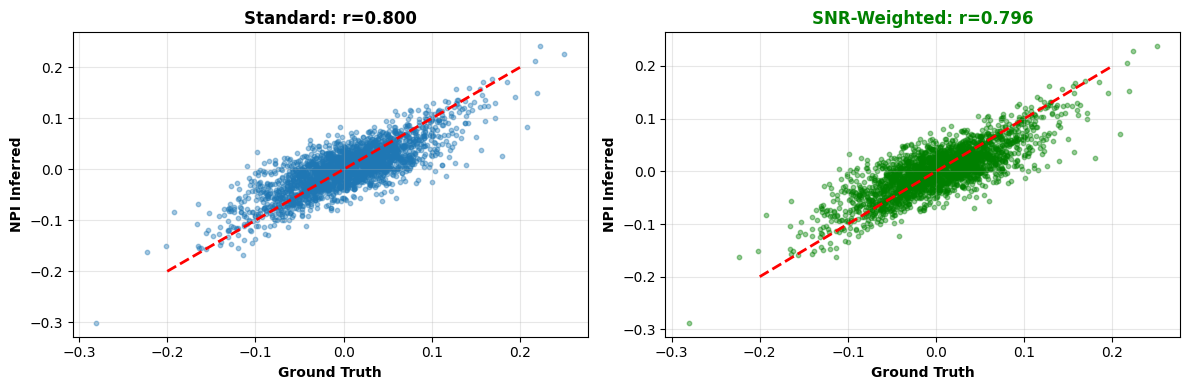

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(flat_without_diagonal(real_EC_snr), flat_without_diagonal(EC_snr_std), alpha=0.4, s=10)
axes[0].plot([-0.2, 0.2], [-0.2, 0.2], 'r--', linewidth=2)
axes[0].set_title(f'Standard: r={r_snr_std:.3f}', fontweight='bold')
axes[0].set_xlabel('Ground Truth', fontweight='bold')
axes[0].set_ylabel('NPI Inferred', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].scatter(flat_without_diagonal(real_EC_snr), flat_without_diagonal(EC_snr_wt), alpha=0.4, s=10, color='green')
axes[1].plot([-0.2, 0.2], [-0.2, 0.2], 'r--', linewidth=2)
axes[1].set_title(f'SNR-Weighted: r={r_snr_wt:.3f}', fontweight='bold', color='green')
axes[1].set_xlabel('Ground Truth', fontweight='bold')
axes[1].set_ylabel('NPI Inferred', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Spatial Smoothing (Thalamic Voxels Merged)

In [ ]:
signals_smooth_fine = np.loadtxt(f'{DATA_DIR}/thalcort_smooth_only_signal.txt')
signals_smooth_coarse = np.loadtxt(f'{DATA_DIR}/thalcort_smooth_only_smoothed_signal.txt')
real_EC_smooth = np.loadtxt(f'{DATA_DIR}/thalcort_smooth_only_real_EC.txt')

with open(f'{DATA_DIR}/thalcort_smooth_only_merge_groups.txt', 'r') as f:
    merge_groups = [list(map(int, line.strip().split(','))) for line in f]

n_merged = len(merge_groups)
print(f'Regions: {signals_smooth_fine.shape[1]} → {signals_smooth_coarse.shape[1]} (merged)')

Regions: 50 → 43 (merged)


### 3.1 Coarse Resolution Only

In [ ]:
inputs_coarse, targets_coarse = NPI.multi2one(signals_smooth_coarse, steps=using_steps)

ANN_coarse = NPI.ANN_MLP(using_steps * n_merged, 2 * n_merged, int(0.8 * n_merged), n_merged)
ANN_coarse, _, _ = NPI.train_NN(ANN_coarse, inputs_coarse, targets_coarse, batch_size, train_set_proportion, num_epochs=100, lr=2.5e-4, l2=5e-5)

EC_coarse = NPI.model_EC(ANN_coarse, inputs_coarse, targets_coarse, pert_strength=1.0)
np.fill_diagonal(EC_coarse, 0)

EC_expanded = map_coarse_to_fine_EC(EC_coarse, merge_groups, ROI_num)
r_coarse = block_correlation(EC_expanded, real_EC_smooth, N_THAL)
print_block_results(r_coarse, 'Coarse Only')


Coarse Only
  r = 0.595


### 3.2 Multi-Resolution Training

In [ ]:
ANN_fine = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
ANN_coarse_multi = NPI.ANN_MLP(using_steps * n_merged, 2 * n_merged, int(0.8 * n_merged), n_merged)

ANN_fine, ANN_coarse_multi, losses = train_multi_resolution(
    ANN_fine, ANN_coarse_multi, signals_smooth_fine, signals_smooth_coarse,
    merge_groups, batch_size, train_set_proportion, num_epochs=100,
    lr=2.5e-4, l2=5e-5, using_steps=using_steps
)

inputs_fine, targets_fine = NPI.multi2one(signals_smooth_fine, steps=using_steps)
EC_multi = NPI.model_EC(ANN_fine, inputs_fine, targets_fine, pert_strength=1.0)
np.fill_diagonal(EC_multi, 0)

r_multi = block_correlation(EC_multi, real_EC_smooth, N_THAL)
print_block_results(r_multi, 'Multi-Resolution')


Multi-Resolution
  r = 0.736


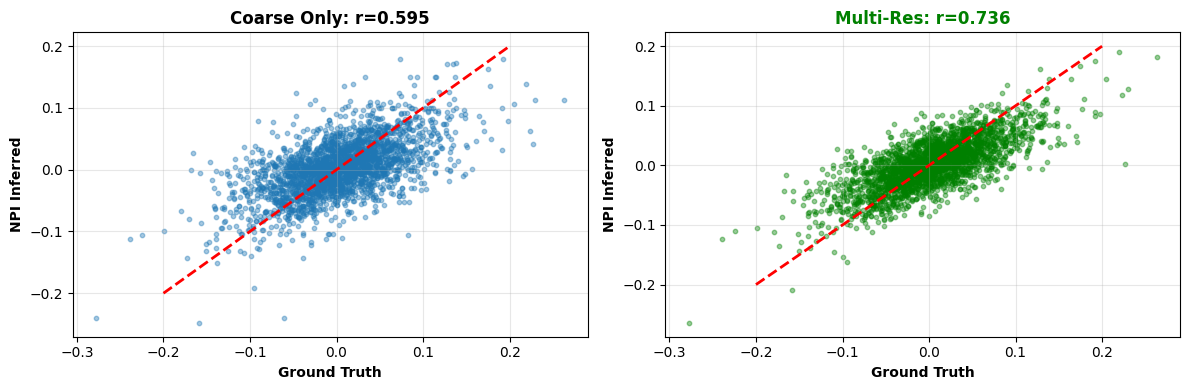

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(flat_without_diagonal(real_EC_smooth), flat_without_diagonal(EC_expanded), alpha=0.4, s=10)
axes[0].plot([-0.2, 0.2], [-0.2, 0.2], 'r--', linewidth=2)
axes[0].set_title(f'Coarse Only: r={r_coarse:.3f}', fontweight='bold')
axes[0].set_xlabel('Ground Truth', fontweight='bold')
axes[0].set_ylabel('NPI Inferred', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].scatter(flat_without_diagonal(real_EC_smooth), flat_without_diagonal(EC_multi), alpha=0.4, s=10, color='green')
axes[1].plot([-0.2, 0.2], [-0.2, 0.2], 'r--', linewidth=2)
axes[1].set_title(f'Multi-Res: r={r_multi:.3f}', fontweight='bold', color='green')
axes[1].set_xlabel('Ground Truth', fontweight='bold')
axes[1].set_ylabel('NPI Inferred', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Realistic Scenario (Low Thal SNR + Thalamic Smoothing)

In [ ]:
signals_real_fine = np.loadtxt(f'{DATA_DIR}/thalcort_realistic_signal.txt')
signals_real_coarse = np.loadtxt(f'{DATA_DIR}/thalcort_realistic_smoothed_signal.txt')
real_EC_real = np.loadtxt(f'{DATA_DIR}/thalcort_realistic_real_EC.txt')
SNR_real = np.loadtxt(f'{DATA_DIR}/thalcort_realistic_SNR.txt')

with open(f'{DATA_DIR}/thalcort_realistic_merge_groups.txt', 'r') as f:
    merge_groups_real = [list(map(int, line.strip().split(','))) for line in f]

n_merged_real = len(merge_groups_real)

inputs_real_fine, targets_real_fine = NPI.multi2one(signals_real_fine, steps=using_steps)
inputs_real_coarse, targets_real_coarse = NPI.multi2one(signals_real_coarse, steps=using_steps)
inputs_real_t = torch.FloatTensor(inputs_real_fine)
targets_real_t = torch.FloatTensor(targets_real_fine)

### 4.1 Standard NPI

In [ ]:
ANN_real_std = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
ANN_real_std, _, _ = NPI.train_NN(ANN_real_std, inputs_real_fine, targets_real_fine, batch_size, train_set_proportion, num_epochs=100, lr=2.5e-4, l2=5e-5)

EC_real_std = NPI.model_EC(ANN_real_std, inputs_real_fine, targets_real_fine, pert_strength=1.0)
np.fill_diagonal(EC_real_std, 0)

r_real_std = block_correlation(EC_real_std, real_EC_real, N_THAL)
print_block_results(r_real_std, 'Realistic (Standard)')


Realistic (Standard)
  r = 0.803


### 4.2 Coarse Only

In [ ]:
ANN_real_coarse = NPI.ANN_MLP(using_steps * n_merged_real, 2 * n_merged_real, int(0.8 * n_merged_real), n_merged_real)
ANN_real_coarse, _, _ = NPI.train_NN(ANN_real_coarse, inputs_real_coarse, targets_real_coarse, batch_size, train_set_proportion, num_epochs=100, lr=2.5e-4, l2=5e-5)

EC_real_coarse = NPI.model_EC(ANN_real_coarse, inputs_real_coarse, targets_real_coarse, pert_strength=1.0)
np.fill_diagonal(EC_real_coarse, 0)

EC_real_coarse_exp = map_coarse_to_fine_EC(EC_real_coarse, merge_groups_real, ROI_num)
r_real_coarse = block_correlation(EC_real_coarse_exp, real_EC_real, N_THAL)
print_block_results(r_real_coarse, 'Realistic (Coarse Only)')


Realistic (Coarse Only)
  r = 0.567


### 4.3 Multi-Resolution Training

In [ ]:
ANN_real_fine = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
ANN_real_coarse_m = NPI.ANN_MLP(using_steps * n_merged_real, 2 * n_merged_real, int(0.8 * n_merged_real), n_merged_real)

ANN_real_fine, ANN_real_coarse_m, _ = train_multi_resolution(
    ANN_real_fine, ANN_real_coarse_m, signals_real_fine, signals_real_coarse,
    merge_groups_real, batch_size, train_set_proportion, num_epochs=100,
    lr=2.5e-4, l2=5e-5, using_steps=using_steps
)

EC_real_multi = NPI.model_EC(ANN_real_fine, inputs_real_fine, targets_real_fine, pert_strength=1.0)
np.fill_diagonal(EC_real_multi, 0)

r_real_multi = block_correlation(EC_real_multi, real_EC_real, N_THAL)
print_block_results(r_real_multi, 'Realistic (Multi-Res)')


Realistic (Multi-Res)
  r = 0.799


### 4.4 Multi-Resolution + SNR Weighting

In [ ]:
ANN_real_fine_snr = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
ANN_real_coarse_snr = NPI.ANN_MLP(using_steps * n_merged_real, 2 * n_merged_real, int(0.8 * n_merged_real), n_merged_real)

ANN_real_fine_snr, ANN_real_coarse_snr, _ = train_multi_resolution(
    ANN_real_fine_snr, ANN_real_coarse_snr, signals_real_fine, signals_real_coarse,
    merge_groups_real, batch_size, train_set_proportion, num_epochs=100,
    lr=2.5e-4, l2=5e-5, using_steps=using_steps
)

EC_real_multi_snr = NPI.model_EC(ANN_real_fine_snr, inputs_real_fine, targets_real_fine, pert_strength=1.0)
EC_real_multi_snr = compute_confidence_weighted_EC(EC_real_multi_snr, SNR_real)
np.fill_diagonal(EC_real_multi_snr, 0)

r_real_multi_snr = block_correlation(EC_real_multi_snr, real_EC_real, N_THAL)
print_block_results(r_real_multi_snr, 'Realistic (Multi-Res + SNR Weighted)')


Realistic (Multi-Res + SNR Weighted)
  r = 0.631


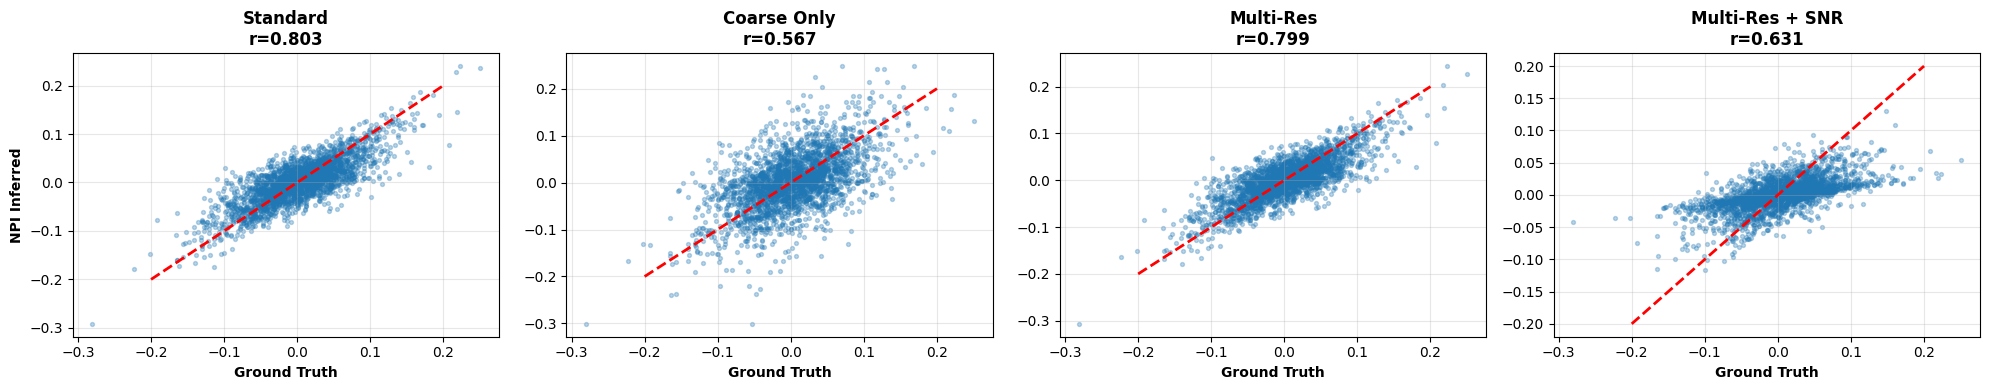

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
methods = [
    (EC_real_std, r_real_std, 'Standard'),
    (EC_real_coarse_exp, r_real_coarse, 'Coarse Only'),
    (EC_real_multi, r_real_multi, 'Multi-Res'),
    (EC_real_multi_snr, r_real_multi_snr, 'Multi-Res + SNR'),
]
for ax, (ec, r, title) in zip(axes, methods):
    ax.scatter(flat_without_diagonal(real_EC_real), flat_without_diagonal(ec), alpha=0.3, s=8)
    ax.plot([-0.2, 0.2], [-0.2, 0.2], 'r--', linewidth=2)
    ax.set_title(f'{title}\nr={r:.3f}', fontweight='bold')
    ax.set_xlabel('Ground Truth', fontweight='bold')
    ax.grid(alpha=0.3)

axes[0].set_ylabel('NPI Inferred', fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Severe Scenario (Very Low Thal SNR + Smoothing)

In [ ]:
signals_sev_fine = np.loadtxt(f'{DATA_DIR}/thalcort_severe_signal.txt')
signals_sev_coarse = np.loadtxt(f'{DATA_DIR}/thalcort_severe_smoothed_signal.txt')
real_EC_sev = np.loadtxt(f'{DATA_DIR}/thalcort_severe_real_EC.txt')
SNR_sev = np.loadtxt(f'{DATA_DIR}/thalcort_severe_SNR.txt')

with open(f'{DATA_DIR}/thalcort_severe_merge_groups.txt', 'r') as f:
    merge_groups_sev = [list(map(int, line.strip().split(','))) for line in f]

n_merged_sev = len(merge_groups_sev)
inputs_sev_fine, targets_sev_fine = NPI.multi2one(signals_sev_fine, steps=using_steps)
inputs_sev_coarse, targets_sev_coarse = NPI.multi2one(signals_sev_coarse, steps=using_steps)

In [ ]:
# Standard
ANN_sev_std = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
ANN_sev_std, _, _ = NPI.train_NN(ANN_sev_std, inputs_sev_fine, targets_sev_fine, batch_size, train_set_proportion, num_epochs=100, lr=2.5e-4, l2=5e-5)
EC_sev_std = NPI.model_EC(ANN_sev_std, inputs_sev_fine, targets_sev_fine, pert_strength=1.0)
np.fill_diagonal(EC_sev_std, 0)
r_sev_std = block_correlation(EC_sev_std, real_EC_sev, N_THAL)

# Coarse only
ANN_sev_coarse = NPI.ANN_MLP(using_steps * n_merged_sev, 2 * n_merged_sev, int(0.8 * n_merged_sev), n_merged_sev)
ANN_sev_coarse, _, _ = NPI.train_NN(ANN_sev_coarse, inputs_sev_coarse, targets_sev_coarse, batch_size, train_set_proportion, num_epochs=100, lr=2.5e-4, l2=5e-5)
EC_sev_coarse = NPI.model_EC(ANN_sev_coarse, inputs_sev_coarse, targets_sev_coarse, pert_strength=1.0)
np.fill_diagonal(EC_sev_coarse, 0)
EC_sev_coarse_exp = map_coarse_to_fine_EC(EC_sev_coarse, merge_groups_sev, ROI_num)
r_sev_coarse = block_correlation(EC_sev_coarse_exp, real_EC_sev, N_THAL)

# Multi-res
ANN_sev_fine = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
ANN_sev_coarse_m = NPI.ANN_MLP(using_steps * n_merged_sev, 2 * n_merged_sev, int(0.8 * n_merged_sev), n_merged_sev)
ANN_sev_fine, ANN_sev_coarse_m, _ = train_multi_resolution(
    ANN_sev_fine, ANN_sev_coarse_m, signals_sev_fine, signals_sev_coarse,
    merge_groups_sev, batch_size, train_set_proportion, num_epochs=100,
    lr=2.5e-4, l2=5e-5, using_steps=using_steps
)
EC_sev_multi = NPI.model_EC(ANN_sev_fine, inputs_sev_fine, targets_sev_fine, pert_strength=1.0)
np.fill_diagonal(EC_sev_multi, 0)
r_sev_multi = block_correlation(EC_sev_multi, real_EC_sev, N_THAL)

print_block_results(r_sev_std, 'Severe (Standard)')
print_block_results(r_sev_coarse, 'Severe (Coarse Only)')
print_block_results(r_sev_multi, 'Severe (Multi-Res)')


Severe (Standard)
  r = 0.799

Severe (Coarse Only)
  r = 0.564

Severe (Multi-Res)
  r = 0.804


## 7. Ensemble Multi-Resolution (Realistic Scenario)

In [ ]:
n_models = 3
EC_ensemble = np.zeros((ROI_num, ROI_num))

for i in range(n_models):
    print(f'  Model {i+1}/{n_models}...')
    ANN_ens_fine = NPI.ANN_MLP(using_steps * ROI_num, 2 * ROI_num, int(0.8 * ROI_num), ROI_num)
    ANN_ens_coarse = NPI.ANN_MLP(using_steps * n_merged_real, 2 * n_merged_real, int(0.8 * n_merged_real), n_merged_real)

    ANN_ens_fine, _, _ = train_multi_resolution(
        ANN_ens_fine, ANN_ens_coarse, signals_real_fine, signals_real_coarse,
        merge_groups_real, batch_size, train_set_proportion, num_epochs=100,
        lr=2.5e-4, l2=5e-5, using_steps=using_steps
    )

    EC_i = NPI.model_EC(ANN_ens_fine, inputs_real_fine, targets_real_fine, pert_strength=1.0)
    np.fill_diagonal(EC_i, 0)
    EC_ensemble += EC_i

EC_ensemble /= n_models
r_ensemble = block_correlation(EC_ensemble, real_EC_real, N_THAL)
print_block_results(r_ensemble, f'Ensemble ({n_models} models)')

  Model 1/3...
  Model 2/3...
  Model 3/3...

Ensemble (3 models)
  r = 0.804


## 8. Larger Model (Realistic Scenario)

In [ ]:
ANN_lg_fine = NPI.ANN_MLP(using_steps * ROI_num, 3 * ROI_num, int(1.2 * ROI_num), ROI_num)
ANN_lg_coarse = NPI.ANN_MLP(using_steps * n_merged_real, 3 * n_merged_real, int(1.2 * n_merged_real), n_merged_real)

ANN_lg_fine, _, _ = train_multi_resolution(
    ANN_lg_fine, ANN_lg_coarse, signals_real_fine, signals_real_coarse,
    merge_groups_real, batch_size, train_set_proportion, num_epochs=100,
    lr=2.5e-4, l2=5e-5, using_steps=using_steps
)

EC_large = NPI.model_EC(ANN_lg_fine, inputs_real_fine, targets_real_fine, pert_strength=1.0)
np.fill_diagonal(EC_large, 0)

r_large = block_correlation(EC_large, real_EC_real, N_THAL)
print_block_results(r_large, 'Larger Model (3xN)')


Larger Model (3xN)
  r = 0.808


In [ ]:
summary = {
    'Baseline': r_base,
    'SNR Only (Std)': r_snr_std,
    'SNR Only (Weighted)': r_snr_wt,
    'Smooth (Coarse)': r_coarse,
    'Smooth (Multi-Res)': r_multi,
    'Realistic (Std)': r_real_std,
    'Realistic (Coarse)': r_real_coarse,
    'Realistic (Multi-Res)': r_real_multi,
    'Realistic (MR+SNR)': r_real_multi_snr,
    'Realistic (Ensemble)': r_ensemble,
    'Realistic (Large)': r_large,
    'Severe (Std)': r_sev_std,
    'Severe (Coarse)': r_sev_coarse,
    'Severe (Multi-Res)': r_sev_multi,
}

print(f'{"Method":<28} {"r":>6}')
print('-' * 36)
for name, r in summary.items():
    print(f'{name:<28} {r:>6.3f}')

Method                            r
------------------------------------
Baseline                      0.753
SNR Only (Std)                0.800
SNR Only (Weighted)           0.796
Smooth (Coarse)               0.595
Smooth (Multi-Res)            0.736
Realistic (Std)               0.803
Realistic (Coarse)            0.567
Realistic (Multi-Res)         0.799
Realistic (MR+SNR)            0.631
Realistic (Ensemble)          0.804
Realistic (Large)             0.808
Severe (Std)                  0.799
Severe (Coarse)               0.564
Severe (Multi-Res)            0.804
